# ITT-MCT Schematic Model: Stress Relaxation

## Learning Objectives

1. Generate **synthetic relaxation data** from NB01 calibrated parameters
2. Understand **two-step relaxation** (β and α processes) in MCT
3. Analyze the **non-ergodicity parameter f** as the long-time plateau
4. Fit the model to verify parameter recovery
5. Compare fluid vs glass relaxation behavior

## Prerequisites

- **NB01: Schematic Flow Curve** (required for calibrated parameters)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~2-3 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~10-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.itt_mct import ITTMCTSchematic

# Add examples/utils to path
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.itt_mct_tutorial_utils import (
    compute_fit_quality,
    compute_non_ergodicity_parameter,
    generate_synthetic_relaxation_schematic,
    load_itt_mct_parameters,
    print_convergence_summary,
    print_glass_state_summary,
    print_parameter_comparison,
    save_itt_mct_results,
    set_model_parameters,
)
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# FAST_MODE: reduced Bayesian samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Stress Relaxation in MCT

### Two-Step Relaxation

Mode-Coupling Theory predicts a characteristic **two-step relaxation**:

1. **Fast β-process**: Initial decay from Φ(0)=1 toward plateau
   - Time scale: τ_β ~ 1/Γ (bare relaxation)
   - Power-law: Φ(t) ~ f + A t^(-a)

2. **Slow α-process**: Final decay from plateau to equilibrium
   - Time scale: τ_α diverges at glass transition
   - Stretched exponential: Φ(t) ~ exp(-(t/τ_α)^β)

### Key Equations

**Correlator equation** (schematic):
$$
\frac{\partial \Phi}{\partial t} + \Gamma\left[\Phi + \int_0^t m(\Phi) \frac{\partial \Phi}{\partial s} ds\right] = 0
$$

**Stress relaxation** after step strain γ₀:
$$
\sigma(t) = G_\infty \gamma_0 \Phi(t)^2 h(\gamma_0)
$$

### Fluid vs Glass

| Property | Fluid (ε < 0) | Glass (ε > 0) |
|----------|---------------|---------------|
| Long-time limit | Φ(∞) = 0 | Φ(∞) = f > 0 |
| α-relaxation | Finite τ_α | τ_α → ∞ |
| Final stress | σ(∞) = 0 | σ(∞) = G∞ γ₀ f² h(γ₀) |

### MCT Exponents

Near the glass transition:
- β-relaxation: Φ ~ f + A t^(-a) with a ≈ 0.3
- α-relaxation: Φ ~ f × exp(-(t/τ_α)^b) with b ≈ 0.5

## 3. Load Calibrated Parameters from NB01

In [3]:
# Load parameters calibrated in NB01
try:
    params = load_itt_mct_parameters("schematic", "flow_curve", require_glass=True)
    print("Loaded parameters from NB01:")
    for name, val in params.items():
        print(f"  {name:10s} = {val:.4g}")
except FileNotFoundError as e:
    print(f"Warning: {e}")
    print("Using default parameters (run NB01 first for calibrated values)")
    params = {"v2": 4.2, "Gamma": 1.0, "gamma_c": 0.1, "G_inf": 1000.0}

Using default glass-state parameters for yield stress calculations.
Loaded parameters from NB01:
  v2         = 4.2
  Gamma      = 1
  gamma_c    = 0.1
  G_inf      = 1000


In [4]:
# Create model and set parameters
model = ITTMCTSchematic(epsilon=0.05)  # Initialize in glass state
set_model_parameters(model, params)

print("\nModel state:")
print(model)
print()
print_glass_state_summary(model)


Model state:
ITTMCTSchematic(ε=0.050 [glass], v₂=4.20, h(γ)=gaussian, m=simplified, σ=schematic, G_inf=1.00e+03 Pa)


Glass Transition State
State: GLASS
Separation parameter: epsilon = 0.0500
Non-ergodicity parameter: f = 0.2381
  -> Correlator plateaus at f > 0 (arrested dynamics)
  -> Material shows yield stress


## 4. Generate Synthetic Relaxation Data

In [5]:
# Generate synthetic data with noise
SIGMA_0 = 100.0  # Initial stress (Pa)
T_END = 100.0    # End time (s)
NOISE_LEVEL = 0.02  # 2% noise

time_data, stress_data = generate_synthetic_relaxation_schematic(
    model,
    sigma_0=SIGMA_0,
    t_end=T_END,
    n_points=200,
    noise_level=NOISE_LEVEL,
    seed=42,
)

print(f"Generated {len(time_data)} data points")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Stress range: [{stress_data.min():.2f}, {stress_data.max():.2f}] Pa")

Generated 200 data points
Time range: [0.0100, 100.00] s
Stress range: [22.33, 37.52] Pa


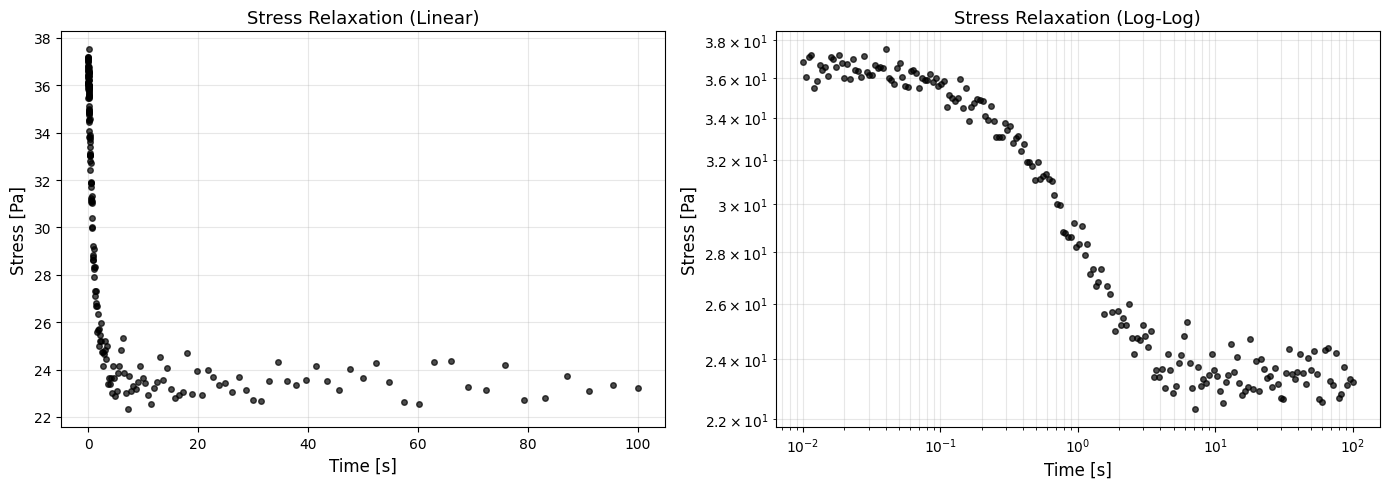

In [6]:
# Plot synthetic data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Linear scale
ax1.plot(time_data, stress_data, "ko", markersize=4, alpha=0.7)
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title("Stress Relaxation (Linear)", fontsize=13)
ax1.grid(True, alpha=0.3)

# Right: Log-log scale
ax2.loglog(time_data, stress_data, "ko", markersize=4, alpha=0.7)
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Stress Relaxation (Log-Log)", fontsize=13)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. NLSQ Fitting

In [7]:
# Compute pre-shear strain for fitting
G_inf = model.parameters.get_value("G_inf")
gamma_pre = SIGMA_0 / G_inf
print(f"Pre-shear strain: γ₀ = σ₀/G∞ = {gamma_pre:.4f}")

Pre-shear strain: γ₀ = σ₀/G∞ = 0.1000


In [8]:
# Fit to relaxation data
param_names = ["v2", "Gamma", "gamma_c", "G_inf"]

t0 = time.time()
model.fit(time_data, stress_data, test_mode="relaxation", gamma_pre=gamma_pre, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    orig = params.get(name, val)
    print(f"  {name:10s} = {val:.4g}  (original: {orig:.4g})")

NLSQ fit time: 7.31 s

Fitted parameters:
  v2         = 0.5  (original: 4.2)
  Gamma      = 1.022  (original: 1)
  gamma_c    = 0.0999  (original: 0.1)
  G_inf      = 1003  (original: 1000)


In [9]:
# Compute fit quality
stress_pred = model.predict(time_data, test_mode="relaxation", gamma_pre=gamma_pre)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R²:   {metrics['R2']:.6f}")
print(f"  RMSE: {metrics['RMSE']:.4g} Pa")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R²:   0.991428
  RMSE: 0.5127 Pa
  NRMSE: 3.3755%


ERROR:rheojax.visualization.plotter:Failed to compute uncertainty band
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/visualization/plotter.py", line 661, in compute_uncertainty_band
    y_fit = np.asarray(model_fn(x_pred, popt), dtype=np.float64)
                       ~~~~~~~~^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/examples/utils/plotting_utils.py", line 52, in _model_fn
    return model.model_function(x, params, test_mode=test_mode, **kwargs)
           ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/itt_mct/schematic.py", line 1223, in model_function
    raise NotImplementedError(
    ...<4 lines>...
    )
NotImplementedError: Bayesian inference is not yet supported for ITT-MCT models. The model requires Prony decomposition that depends on parameters (v1, v2), making MCMC sampling computationally prohibitive. Use NLSQ fitting with bootstrap resampling for uncertaint

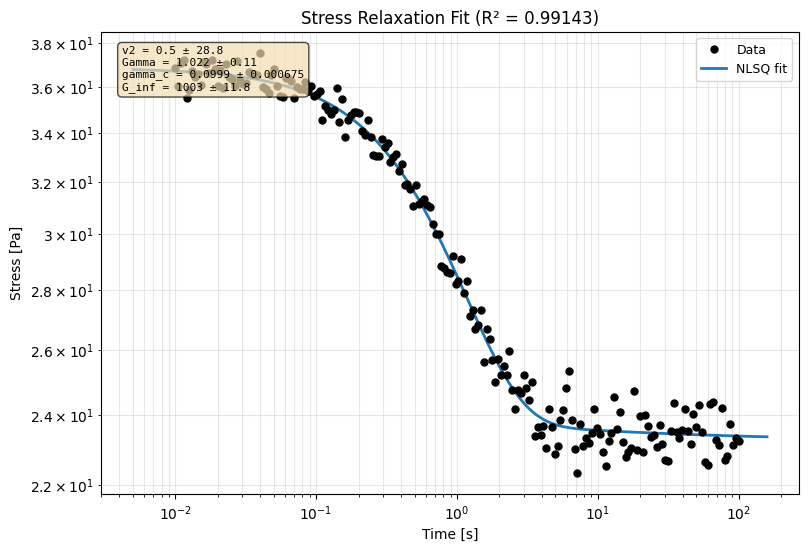

In [10]:
# Plot NLSQ fit with uncertainty band
fig, ax = plot_nlsq_fit(
    time_data, stress_data, model, test_mode="relaxation",
    param_names=param_names,
    log_scale=True,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title=f"Stress Relaxation Fit (R\u00b2 = {metrics['R2']:.5f})",
    gamma_pre=gamma_pre,
)
display(fig)
plt.close(fig)

### 5.1 Physical Analysis: Two-Step Relaxation

In [11]:
# Analyze two-step relaxation
print("Two-Step Relaxation Analysis")
print("=" * 50)

v2 = model.parameters.get_value("v2")
Gamma = model.parameters.get_value("Gamma")
f_neq = compute_non_ergodicity_parameter(0, v2)
info = model.get_glass_transition_info()

# Time scales
tau_beta = 1.0 / Gamma  # β-relaxation

print(f"\nβ-process (fast):")
print(f"  Time scale: τ_β = 1/Γ = {tau_beta:.4g} s")
print(f"  Physics: Rattling within cage")

print(f"\nα-process (slow):")
if info["is_glass"]:
    print(f"  Time scale: τ_α → ∞ (glass state)")
    print(f"  Physics: Cage breaking arrested")
else:
    # Estimate alpha relaxation time
    epsilon = (v2 - 4) / 4
    tau_alpha = tau_beta * abs(epsilon)**(-2.5) if epsilon < 0 else float('inf')
    print(f"  Time scale: τ_α ≈ {tau_alpha:.4g} s")
    print(f"  Physics: Cage rearrangement")

print(f"\nPlateau:")
print(f"  Non-ergodicity parameter: f = {f_neq:.4f}")
if info["is_glass"]:
    print(f"  Stress plateau: σ_∞ > 0 (residual stress)")
else:
    print(f"  Stress plateau: σ_∞ = 0 (complete relaxation)")

Two-Step Relaxation Analysis

β-process (fast):
  Time scale: τ_β = 1/Γ = 0.9788 s
  Physics: Rattling within cage

α-process (slow):
  Time scale: τ_α ≈ 1.367 s
  Physics: Cage rearrangement

Plateau:
  Non-ergodicity parameter: f = 0.0000
  Stress plateau: σ_∞ = 0 (complete relaxation)


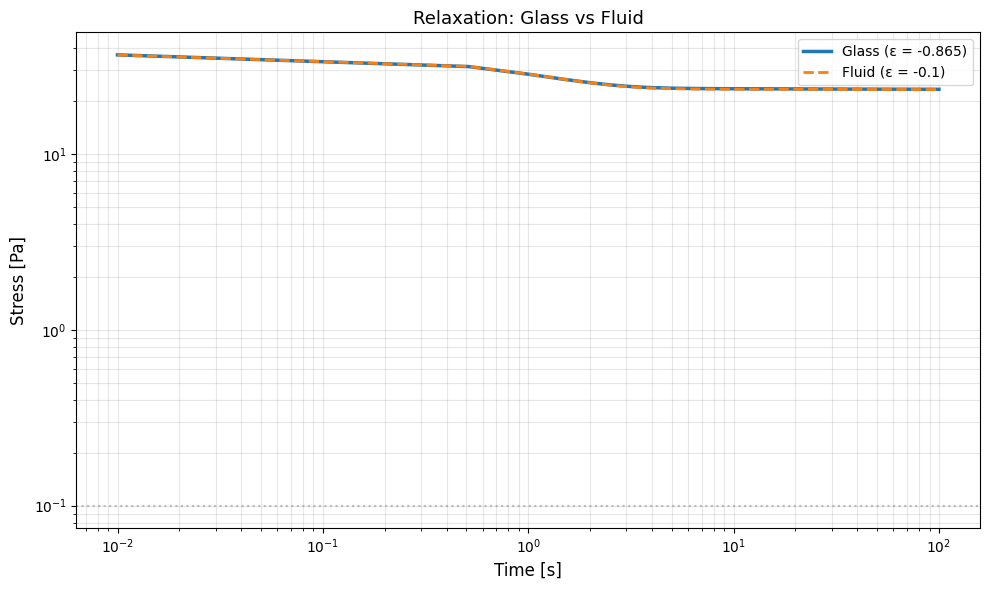

In [12]:
time_fine = np.linspace(time_data.min(), time_data.max(), 200)
stress_pred_fine = model.predict(time_fine, test_mode='relaxation', gamma_pre=gamma_pre)

# Compare fluid vs glass relaxation
fig, ax = plt.subplots(figsize=(10, 6))

# Glass state (current)
ax.loglog(time_fine, stress_pred_fine, "-", lw=2.5, color="C0", 
          label=f"Glass (ε = {info['epsilon']:.3f})")

# Simulate fluid state
model_fluid = ITTMCTSchematic(epsilon=-0.1)  # Fluid
set_model_parameters(model_fluid, params)
model_fluid.parameters.set_value("v2", 3.6)  # Below critical
stress_fluid = model_fluid.predict(time_fine, test_mode="relaxation", gamma_pre=gamma_pre)
ax.loglog(time_fine, stress_fluid, "--", lw=2, color="C1", 
          label="Fluid (ε = -0.1)")

ax.axhline(1e-1, color="gray", linestyle=":", alpha=0.5)
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("Relaxation: Glass vs Fluid", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference

In [13]:
try:
    # Prepare warm-start
    initial_values = {
        name: model.parameters.get_value(name)
        for name in param_names
    }
    
    if FAST_MODE:
        NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 50, 100, 1
    else:
        NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 1000, 2000, 4
    
    print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
    t0 = time.time()
    result = model.fit_bayesian(
        time_data,
        stress_data,
        test_mode="relaxation",
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
except (NotImplementedError, RuntimeError, AttributeError) as e:
    print(f"Note: {e}")
    print("NLSQ results are reported above.")
    result = None


ERROR:rheojax.core.bayesian:NUTS sampling failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 720, in _run_nuts_sampling
    result = run_mcmc(init_strategy)
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 715, in run_mcmc
    sampler.run(rng_key, X_jax, y_jax)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 702, in run
    states_flat, last_state = partial_map_fn(map_args)
                              ~~~~~~~~~~~~~~^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 465, in _single_chain_mcmc
    new_init_state = self.sampler.init(
        rng_key,
    ...<3 lines>...
        model_kwargs=kwargs,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/hmc.py", line 751, in init
    init_params = self._init_stat

ERROR:rheojax.core.bayesian:bayesian_inference failed: NUTS sampling failed: Bayesian inference is not yet supported for ITT-MCT models. The model requires Prony decomposition that depends on parameters (v1, v2), making MCMC sampling computationally prohibitive. Use NLSQ fitting with bootstrap resampling for uncertainty quantification.


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 720, in _run_nuts_sampling
    result = run_mcmc(init_strategy)
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 715, in run_mcmc
    sampler.run(rng_key, X_jax, y_jax)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 702, in run
    states_flat, last_state = partial_map_fn(map_args)
                              ~~~~~~~~~~~~~~^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 465, in _single_chain_mcmc
    new_init_state = self.sampler.init(
        rng_key,
    ...<3 lines>...
        model_kwargs=kwargs,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/hmc.py", line 751, in init
    init_params = self._init_state(
  

Running NUTS: 50 warmup + 100 samples x 1 chain(s)
Note: NUTS sampling failed: Bayesian inference is not yet supported for ITT-MCT models. The model requires Prony decomposition that depends on parameters (v1, v2), making MCMC sampling computationally prohibitive. Use NLSQ fitting with bootstrap resampling for uncertainty quantification.
NLSQ results are reported above.


In [14]:
if result is not None:
    # Convergence diagnostics
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [15]:
if result is not None:
    display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")

Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [16]:
if result is not None:
    # Parameter comparison
    posterior = result.posterior_samples
    print_parameter_comparison(model, posterior, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


## 7. Physical Interpretation

### MCT Relaxation Signatures

1. **β-relaxation** (t ~ τ_β):
   - Fast decay due to particle vibrations within cage
   - Followed by plateau toward non-ergodicity parameter f

2. **α-relaxation** (t ~ τ_α):
   - Slow decay from cage rearrangement
   - In glass: τ_α → ∞, stress plateaus
   - In fluid: finite τ_α, stress decays to zero

3. **Residual stress** (glass only):
   - σ_∞ = G∞ × γ₀ × f² × h(γ₀)
   - Non-zero due to arrested dynamics

In [17]:
# Summary
print("Stress Relaxation Summary")
print("=" * 50)
print_glass_state_summary(model)
print(f"\nRelaxation Characteristics:")
print(f"  Initial stress: σ₀ = {SIGMA_0:.1f} Pa")
print(f"  Pre-shear strain: γ₀ = {gamma_pre:.4f}")
print(f"  β time scale: τ_β = {1/Gamma:.4g} s")
if info["is_glass"]:
    print(f"  α time scale: τ_α → ∞ (glass)")
    print(f"  Residual stress: σ_∞ > 0")

Stress Relaxation Summary

Glass Transition State
State: FLUID
Separation parameter: epsilon = -0.8650
  -> Correlator decays to 0 (ergodic dynamics)
  -> Material flows like a viscous liquid

Relaxation Characteristics:
  Initial stress: σ₀ = 100.0 Pa
  Pre-shear strain: γ₀ = 0.1000
  β time scale: τ_β = 0.9788 s


## 8. Save Results

In [18]:
# Save results
save_itt_mct_results(model, result, "schematic", "relaxation", param_names)
print("\nRelaxation results saved.")

  Skipping posterior (Bayesian inference not available for ITT-MCT)
Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/itt_mct/schematic/relaxation/
  nlsq_params_relaxation.json: 4 parameters

Relaxation results saved.


## Key Takeaways

1. **Two-step relaxation** is a hallmark of MCT:
   - Fast β-process (cage vibration)
   - Slow α-process (cage rearrangement)

2. **Glass state** (ε > 0) shows:
   - Residual stress σ_∞ > 0
   - Plateau at non-ergodicity parameter f
   - Arrested α-relaxation (τ_α → ∞)

3. **Fluid state** (ε < 0) shows:
   - Complete relaxation to σ_∞ = 0
   - Finite α-relaxation time τ_α

4. **Parameter recovery** from synthetic data validates model

### Next Steps

- **NB04:** Creep (delayed yielding)
- **NB05:** SAOS (G' plateau from f)